In [1]:
import numpy as np
from torch import nn
import gymnasium as gym
import matplotlib.pyplot as plt
from stable_baselines3.common.preprocessing import get_flattened_obs_dim

from rlmcmc.env import RLMHEnv
from rlmcmc.policy import RLMHTD3PolicyCovarianceNoise
from rlmcmc.agent import RLMHDDPG
from rlmcmc.utils import RLMHChi2CovNoise, RLMHHalfCauchyCovNoise

import json
import pandas as pd
import bridgestan as bs
from posteriordb import PosteriorDatabase

from mcmctoolbox.functoolbox import flat

In [2]:
# Load DataBase Locally
pdb_path = "/home/congye/Code/PythonProjects/LearningAdaptiveMCMC/Python/posteriordb/posterior_database"
my_pdb = PosteriorDatabase(pdb_path)

# Load Dataset
posterior = my_pdb.posterior("test-SimpleEggBox-test-SimpleEggBox")
stan = posterior.model.stan_code_file_path()
data = json.dumps(posterior.data.values())
model = bs.StanModel.from_stan_file(stan, data)

# Gold Standard
gs = posterior.reference_draws()
df = pd.DataFrame(gs)
gs_chains = np.zeros(
    (
        sum(flat(posterior.information["dimensions"].values())),
        posterior.reference_draws_info()["diagnostics"]["ndraws"],
    )
)
for i in range(len(df.keys())):
    s = []
    for j in range(len(df[df.keys()[i]])):
        s += df[df.keys()[i]][j]
    gs_chains[i, :] = s
linv = np.linalg.inv(np.cov(gs_chains))

# Extract log-P-pdf and its gradient
log_p = model.log_density


total_timesteps = 5_000
rlmh_env = gym.make(
    "RLMHEnv-v0", log_target_pdf=log_p, sample_dim=2, total_timesteps=total_timesteps
)

In [3]:
# Covariance Matrix Noise
# cov_noise = RLMHChi2CovNoise(noise_df=4)
cov_noise = RLMHHalfCauchyCovNoise(scale=2.0)

In [4]:
policy_kwargs = dict(
    net_arch=dict(pi=[64, 64], qf=[64, 64]),
    activation_fn=nn.Softplus,
    n_critics=1,
    covariance_noise=cov_noise
)

In [5]:
model = RLMHDDPG(
    RLMHTD3PolicyCovarianceNoise,
    rlmh_env,
    seed=1234,
    policy_kwargs=policy_kwargs,
    learning_starts=-1,
    batch_size=64,
    train_freq=(2, "step"),
    action_noise=None,
    device="cpu",
    verbose=2,
)

model.learn(total_timesteps=total_timesteps, progress_bar=True)


state_list = np.array([i for i in rlmh_env.store_state]).reshape(
    -1, get_flattened_obs_dim(rlmh_env.observation_space)
)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Output()

/home/congye/miniconda3/envs/rl/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:58: 
RuntimeWarning: overflow encountered in cast
  obs, self.buf_rews[env_idx], terminated, truncated, self.buf_infos[env_idx] = self.envs[env_idx].step(

/home/congye/miniconda3/envs/rl/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.store_state to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.store_state` for environment variables or `env.get_wrapper_attr('store_state')` that will search the reminding wrappers.
  logger.warn(


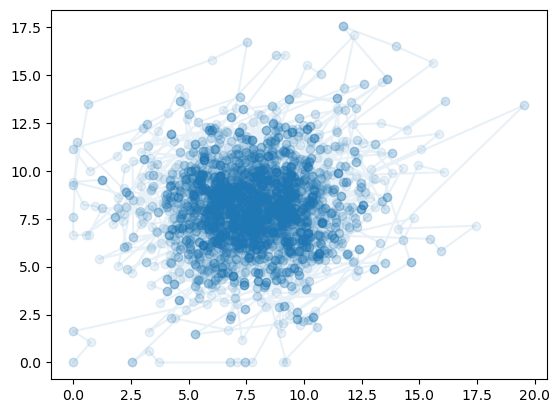

In [6]:
# Trace Plot
plt.plot(state_list[:, 0], state_list[:, 1], "o-", alpha=0.1)
plt.show()

In [7]:
model.policy_kwargs

{'net_arch': {'pi': [64, 64], 'qf': [64, 64]},
 'activation_fn': torch.nn.modules.activation.Softplus,
 'n_critics': 1,
 'covariance_noise': RLMHHalfCauchyCovNoise(
 	scale=2.0
 )}